![logo.png](https://github.com/interviewquery/takehomes/blob/origin/uber_3/uber_3/logo.png?raw=1)


## Part 1 - SQL Syntax

Given the below subset of Uber's schema, write executable SQL queries to answer the questions below. Please answer in a single query for each question and assume read-only access to the database (i.e. do not use CREATE TABLE).

1. For each of the cities 'Qarth' and 'Meereen', calculate 90 th percentile difference between Actual and Predicted ETA for all completed trips within the last 30 days.

2. A signup is defined as an event labeled `sign_up_success` within the `events` table. For each city ('Qarth' and 'Meereen') and each day of the week, determine the percentage of signups in the first week of 2016 that resulted in completed a trip within 168 hours of the sign up date.

**Assume a PostgreSQL database, server timezone is UTC.**


Table Name: **`trips`**

|Column Name:|Datatype:|
| :-: | :-: |
|`id`|`integer`|
|`client_id`|`integer` (Foreign keyed to `events.rider_id`)|
|`driver_id`|`integer`|
|`city_id`|`integer` (Foreign keyed to `cities.city_id`)|
|`client_rating`|`integer`|
|`driver_rating`|`integer`|
|`request_at`|`Timestamp with timezone`|
|`predicted_eta`|`integer`|
|`actual_eta`|`integer`|
|`status`|`Enum`(‘`completed`’, ‘`cancelled_by_driver`’, ‘`cancelled_by_client`’)|


Table Name: **`cities`**

|Column Name:|Datatype:|
| :-: | :-: |
|`city_id`|`integer`|
|`city_name`|`string`|



Table Name: **`events`**

|Column Name:|Datatype:|
| :-: | :-: |
|`device_id`|`integer`|
|`rider_id`|`integer`|
|`city_id`|`integer`|
|`event_name`|`Enum`(‘`sign_up_success`’, ‘`attempted_sign_up`’, ‘`sign_up_failure`’)|



## Part 2 - Experiment and metrics design


The Driver Experience team has just finished [redesigning the Uber Partner app](https://newsroom.uber.com/new-partner-app/). The new version expands the purpose of the app beyond just driving. It includes additional information on earnings, ratings, and provides a unified platform for Uber to communicate with its partners.

1. Propose and define the primary success metric of the redesigned app. What are 2-3 additional tracking metrics that will be important to monitor in addition to the success metric defined above?

2. Outline a testing plan to evaluate if redesigned app performs better (according to the metrics you outlined). How would you balance the need to deliver quick results, with statistical rigor, and while still monitoring for risks?

3. Explain how you would translate the results from the testing plan into a decision on whether to launch the new design or roll it back.

## Part 3 - Data analysis

Uber's Driver team is interested in predicting which driver signups are most likely to start driving. To help explore this question, we have provided a sample  dataset of a cohort of driver signups in January 2015.The data was pulled a few months after they signed up to include the result of whether they actually completed their first trip. It also includes several pieces of background information gather about the driver and their car.

We would like you to use this data set to help understand what factors are best at predicting whether a signup will start to drive, and offer suggestions to operationalize those insights to help Uber.

See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge. Please also call out any data related assumptions or issues that you encounter.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the driver signups took a first trip?

2. Build a predictive model to help Uber determine whether or not a driver signup will start driving. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Uber might leverage the insights gained from the model to generate more first trips (again, a few ideas/sentences will suffice).



### Data description

**id**: driver_id

**city_id**: city_id this user signed up in

**signup_os**: signup device of the user ("android", "ios", "website", "other")

**signup_channel**: what channel did the driver sign up from ("offline", "paid", "organic", "referral")

**signup_timestamp**: timestamp of account creation; local time in the form 'YYYY/MM/DD'

**bgc_date**: date of background check consent; in the form 'YYYY/MM/DD'

**vehicle_added_date**: date when driver's vehicle information was uploaded; in the form 'YYYY/MM/DD'

**first_trip_date**: date of the first trip as a driver; in the form 'YYYY/MM/DD'

**vehicle_make**: make of vehicle uploaded (i.e. Honda, Ford, Kia)

**vehicle_model**: model of vehicle uploaded (i.e. Accord, Prius, 350z)

**vehicle year**: year that the car was made; in the form 'YYYY'




Please note that this data is fake and does not represent actual driver signup behavior



In [1]:
!git clone --branch origin/uber_3 https://github.com/interviewquery/takehomes.git
%cd takehomes/uber_3
!if [[ $(ls *.zip) ]]; then unzip *.zip; fi
!ls

Cloning into 'takehomes'...
remote: Enumerating objects: 1963, done.
remote: Counting objects: 100% (1963/1963), done.
remote: Compressing objects: 100% (1220/1220), done.
remote: Total 1963 (delta 752), reused 1927 (delta 726), pack-reused 0 (from 0)
Receiving objects: 100% (1963/1963), 297.43 MiB | 11.82 MiB/s, done.
Resolving deltas: 100% (752/752), done.
/content/takehomes/uber_3
ls: cannot access '*.zip': No such file or directory
ds_challenge_v2_1_data.csv  logo.png  takehomefile.ipynb


# Solutions

## Part 1  - SQL Syntax

In [ ]:
%%sql
--1.

select
  c.city_name,
  percentile_disc(0.90) within group (
    order by t.actual_eta-t.predicted_eta
  ) 90th_percentile
from trips t
inner join cities c ON t.city_id = c.city_id
where ifnull(c.city_name, 'null') in ('Qarth', 'Meereen')
and t.status = 'completed'
and t.request_at >= now() - interval '30 days'
group by c.city_name
;

SyntaxError: invalid syntax (<ipython-input-8-fe03050a5966>, line 2)

In [ ]:
%%sql
--2. Im going to assume first week of 2016 refers to Jan 1-7th of 2016 and that
--eta is in minutes
--There does not seem to be a way to distinguish between a sign-up date and a request_at date?

select c.city_name, n_completed_trips/n_requests*100 signups_with_completed_trips
from
(select c.city_name, count(id) n_completed_trips
from trips t
inner join events e ON t.client_id = e.rider_id
inner join cities c ON c.city_id = e.city_id
where e.event_name = 'sign_up_success'
and ifnull(c.city_name, 'null') in ('Qarth', 'Meereen')
and t.status = 'completed'
and t.request_at >= '2016-01-01'
and t.request_at < '2016-01-08'
and t.actual_eta < 168 * 60
group by c.city_name) sub1
inner join
(select c.city_name, count(id) n_requests
from trips t
inner join events e ON t.client_id = e.rider_id
inner join cities c ON c.city_id = e.city_id
where e.event_name = 'sign_up_success'
and ifnull(c.city_name, 'null') in ('Qarth', 'Meereen')
and t.request_at >= '2016-01-01'
and t.request_at < '2016-01-08'
group by c.city_name) sub2 ON sub1.city_name = sub2.city_name
;

## Part 2 -- Experiments and metrics design

What changes have been made?



Original App

    Facilitates the driving process

New App

    Offers comprehensive information on earnings

    Offers comprehensive information on driver ratings

    Unified platform for drivers to communicate with Uber



I would expect this to give drivers a better understanding of how their income is calculated, why some rides/deliveries get them more money than others, what factors they could focus on to optimize their earnings.



I would expect the rating information to help drivers understand better where they might be losing ratings on, what they do well and don't do well when it comes to helping customers.



Easier for drivers to communicate with Uber if any issues in an order, with a passenger, law enforcement, whatever comes up.



How would I expect these changes to impact driver behavior?



-if the uber partners app gives clearer insight to drivers than competitors apps, then they might prefer using Uber

-increase in driver engagement in higher paid areas (surge pricing, times of higher customer demand)

-an increase in drivers behaving in a way to get around loopholes (e.g. calling customers at the airport to determine how long the ride would be)

-decrease in driver engagement in less profitable areas

-improvement in driver ratings, especially with beginner drivers

-increased beginning driver retention

-increased messages to Uber from drivers or perhaps decreased messages if the other features improve clarity



What metrics would be impacted?



-app rating after the changes

-app review sentiment

-app downloads

-app uninstalls

-app ranking in category

-smaller gap between driver supply and customer demand?

-more logins per week

-lower churn, increase in new accounts and better retention of those new accounts

-earnings of new drivers gone up



I would expect the app redesign to have the biggest impact on new drivers. Longtime drivers are more familiar with the app and more settled in their routines. I would expect app review sentiment to improve, but many people don't take the time to review apps.  



Metric: Reduced new driver churn- a higher percentage of a "cohort" of new drivers (e.g. drivers that joined in January) are still driving 6 months later.

-I would expect the changes to improve the experience

-I would expect the changes to have the highest impact on new drivers

-Can involve all new drivers, all new drivers will have some level of engagement (even if that level is 0) but not all will write reviews

-more directly related to app value (satisying customers, engagement with product) than something like a review



If my hypothesis is right that the app changes are responsible for less churn, what other behavior would I expect to see?



-higher ratings of the Partners App by new drivers (this might be better than review sentiment since people are more likely to give reviews to complain)

-higher ratings of new drivers by customers



What if I see less churn but it is not due to the app changes?

-be aware of what else is going on in the environment. Did a competitor get banned in a service area or something else happen in the news (an app got "cancelled" so more customers are using Uber and more drivers have to switch to get the customers)

-maybe an unrelated software bug was fixed?

-a promo for new drivers was going on?



Additional secondary metrics:

-app ratings by driver experience

-app review sentiment by driver experience



Conduct an A/B test with randomized cohorts of partners in a test group and a control group. Make sure both groups are relatively representative of the cross-section of drivers where the change is applied. Also perhaps compare with historical data on driver churn.  



Real-time monitoring of review sentiments and ratings



Final decision.

-Can we trace out a potential logic chain?

-Are there any results that surprised us or are unexpected?

-Is there different behavior for different user cohorts?

## Part 3 -- Data Analysis

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('ds_challenge_v2_1_data.csv')
df.head()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")
/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")
/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN


In [10]:
df.isna().any()

,0
id,False
city_name,False
signup_os,True
signup_channel,False
signup_date,False
bgc_date,True
vehicle_added_date,True
vehicle_make,True
vehicle_model,True
vehicle_year,True


In [40]:
df.notna().sum() #54681 signups, 32896 bgc, 13134 vehicle added, 6137 driven

,0
id,54681
city_name,54681
signup_os,47824
signup_channel,54681
signup_date,54681
bgc_date,32896
vehicle_added_date,13134
vehicle_make,13223
vehicle_model,13223
vehicle_year,13223


In [16]:
df.city_name.unique(), df.signup_channel.unique(), min(df.signup_date), max(df.signup_date)

(array(['Strark', 'Wrouver', 'Berton'], dtype=object),
 array(['Paid', 'Organic', 'Referral'], dtype=object),
 '1/1/16',
 '1/9/16')

In [17]:
df[~df.first_completed_date.isna()].first_completed_date.min(), df[~df.first_completed_date.isna()].first_completed_date.max()

('1/10/16', '2/9/16')

In [20]:
df.vehicle_year.min(), df.vehicle_year.max(), df[df.vehicle_year > 0].vehicle_year.min()

(0.0, 2017.0, 1995.0)

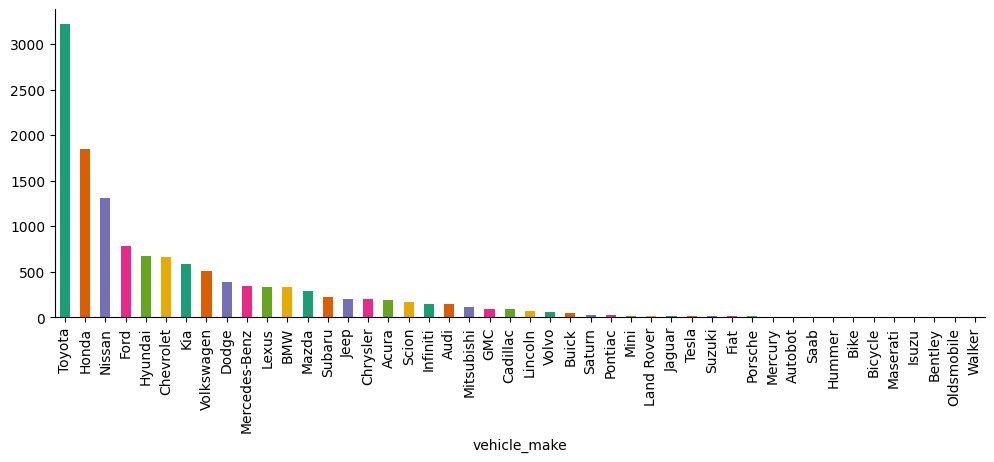

In [39]:
plt.figure(figsize=(12, 4))
df.groupby('vehicle_make').size().sort_values(ascending=False).plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

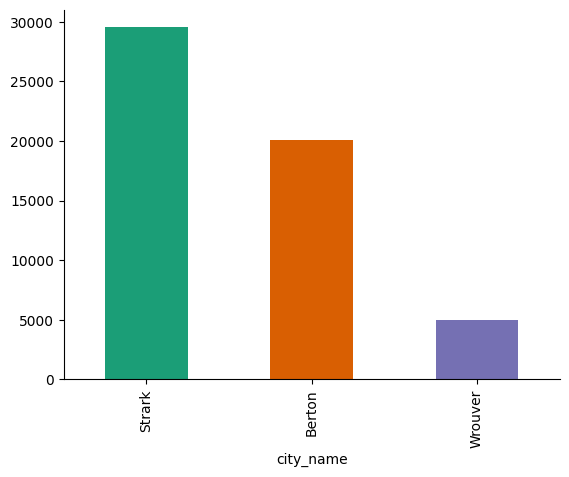

In [37]:
df.groupby('city_name').size().sort_values(ascending=False).plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

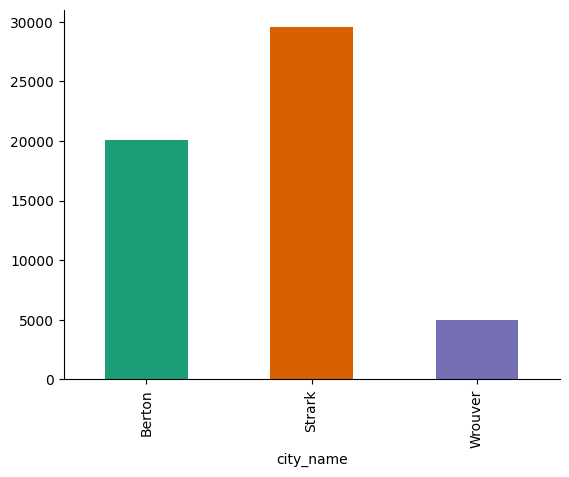

In [29]:
# @title city_name

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('city_name').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)